#**Detecting Fake Reviews**

We will revisit this problem, seeing how sequence models can perform (perhaps they fare better than the simple unigram or bigram dense networks. Recall that this dataset is the product of research by a few folks in Computer Science: https://aclanthology.org/N13-1053.pdf.

In [ ]:
import random 
import numpy as np
import tensorflow as tf
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from google.colab import files
import pandas as pd
import io
import numpy as np

# Just load the data from the Week 3 folder again.
trip_advisor = pd.read_csv('https://raw.githubusercontent.com/gburtch/BA865-2023/main/Lecture%20Materials/C/dataset/deceptive-opinion.csv')
trip_advisor = trip_advisor.sample(frac=1) # Shuffle the data since I'll eventually just use a simple validation split.

trip_advisor.describe(include='all')

# Let's shuffle things... 
shuffled_indices= np.arange(trip_advisor.shape[0])
np.random.shuffle(shuffled_indices)

trip_advisor_text = trip_advisor['text'].to_numpy()
label = np.where(trip_advisor['deceptive']=='deceptive',1,0)

print(trip_advisor_text)
trip_advisor_text = trip_advisor_text[shuffled_indices]
label = label[shuffled_indices]
print(trip_advisor_text)

['This is the hotel for the discriminating business traveler. It offers spacious rooms that are elegant and refined. With a cozy area complete with chairs and fireplace, they are the perfect place to entertain clients or discuss strategy for a business meeting with a colleague. The restaurant offers just the location to impress a perspective client. And all of this elegance and refinement in the heart of downtown Chicago\n'
 'What a wonderful experience, super great, helpful, friendly staff. Angie at the front desk made sure my husbands birthday would be great. Our room was beautiful. Angie suggested we go to Sullivans for dinner..perfect choice, make the reservation for us.(best seat in the house and a special dessert) wow...Above and beyond what any other hotel or staff has done for us before..Looking forward to staying there again & again. THANKS AGAIN \n'
 'I stayed at the Talbott twice in the last few weeks. I was very pleased with every facet of my stays. The staff, from doormen 

Let's make a TextVectorization() layer to preprocess our text. Note, by default, this will make words lowercase, remove punctuation, and split on white space.

In [ ]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=2000, # We will use the 2000 most frequent terms.
    output_mode="int", # This is requesting integer encodings (which means we'll have a sequence of integers)
    #ragged=True, # This returns a ragged list (sequences of variable length); absent this, the vectorizer will pad. 
)

text_vectorization.adapt(trip_advisor_text)

Just to see what this layer is doing to our reviews... 

In [ ]:
review_text = trip_advisor_text[0]
print(f'REVIEW TEXT: \n\n{review_text}')
review_len = len(review_text.split(' '))
print(f'REVIEW DETAILS: \n\nThe review contains roughly {review_len} words (based on white spaces).')
vectorized_review = text_vectorization(trip_advisor_text)
print(f'It\'s vectorized (and padded) form contains {vectorized_review.shape[1]} tokens.\n') #Including the start index.
print(f'VECTOR REPRESENTATION:\n')
vectorized_review[0] # This text vectorization layer will convert a raw text vector into a sequence of integers.

REVIEW TEXT: 

This is an older hotel, and the age shows. Rooms are small, and a bit drab. Bathroom in my room was in urgent need of upgrade. Bed was comfortable, though, and the room was quiet, Hotel staff was polite, but not really interested in the guest. Even the concierge was disinterested. Check-in was irritatingly slow for the few number of people in line. Really, a hotel tjhat promises so much in its promotional material should deliver better. The hotel really didnt seem to be trying.

REVIEW DETAILS: 

The review contains roughly 85 words (based on white spaces).
It's vectorized (and padded) form contains 784 tokens.

VECTOR REPRESENTATION:



<tf.Tensor: shape=(784,), dtype=int64, numpy=
array([  23,   17,   49, 1040,   10,    3,    2,    1, 1499,   47,   44,
        143,    3,    5,  276,    1,   91,    8,   16,   13,    7,    8,
          1,  227,    9,  604,   73,    7,  105,  200,    3,    2,   13,
          7,  419,   10,   42,    7,  750,   26,   21,   99, 1700,    8,
          2,  298,   69,    2,  246,    7,    1,  311,    7,    1,  512,
         12,    2,  211,  841,    9,  174,    8,  388,   99,    5,   10,
          1,    1,   41,  116,    8,   90,    1,    1,  275, 1189,  121,
          2,   10,   99,   98,  634,    4,   34,  619,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

Before we proceed, do we expect a Sequence model to be helpful here (versus a bag of words model)? Recall, we should check the ratio of observations in training to mean number of tokens per sample. We don't expect to get much value at all from a sequential text model in this case, because we would need a much bigger dataset (on the order of 2.5 million observations). 

In [ ]:
lengths = [len(x) for x in vectorized_review]

print(f'The average review in our data will be less than {np.mean(lengths)} words, and we have {len(trip_advisor)} samples.')
print(f'The ratio of samples to average sample length is thus {len(trip_advisor)/np.mean(lengths)}. We are nowhere close to 1500.')

The average review in our data will be less than 784.0 words, and we have 1600 samples.
The ratio of samples to average sample length is thus 2.0408163265306123. We are nowhere close to 1500.


#*Model Using a 1D Convolution*

We will one-hot encode these integer sequences into sparse, binary vector sequences, i.e., whereas a particular review would have been a one dimensional vector of integers (one integer per word), now we will have a two-dimensional array, with one vector per word. I'll show you what this function does here... 

In [ ]:
one_hot_review = tf.one_hot(vectorized_review, depth=2000) # Depth is the number of unique tokens in our sample (our vectorizer made it so we have no more than 2000)
print(one_hot_review.shape)

(1600, 784, 2000)


We one-hot encode the vectorized input, then pass it to a 1D convolution layer. Here, we will try a 'SeparableConv1D' layer (it's a simplified version of the Conv1D (fewer parameters, by breaking the convolution calculation into smaller steps. 

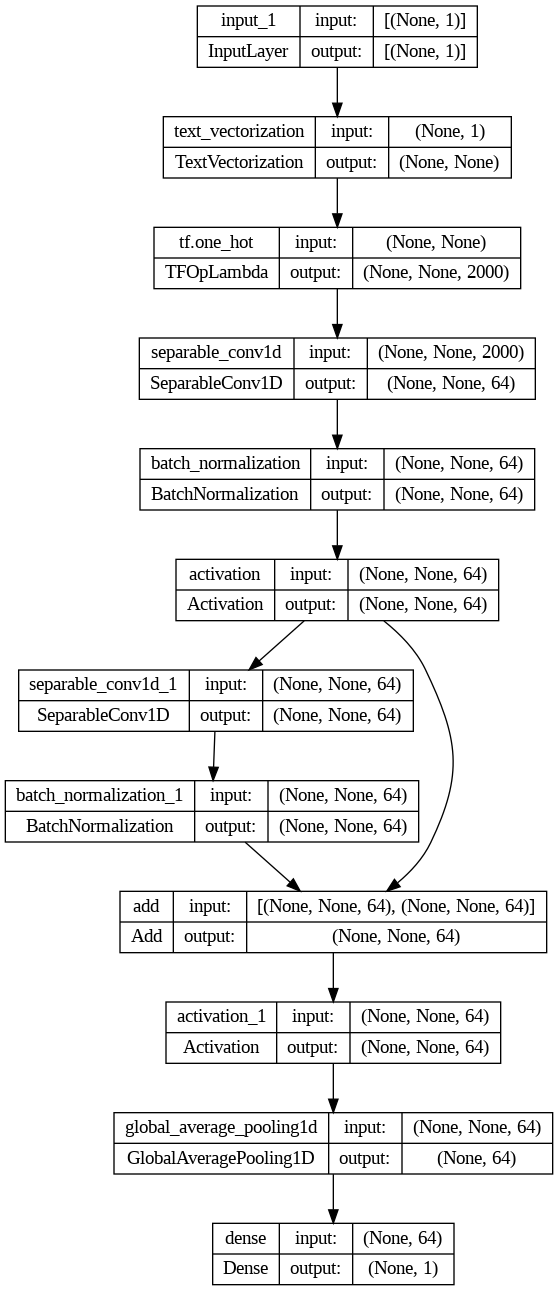

In [ ]:
def build_model():
    inputs = keras.layers.Input(shape=(1), dtype="string") # We take our strings as input 
    processing = text_vectorization(inputs)
    one_hot = tf.one_hot(processing, depth=2000) # we one-hot encode those, so it becomes a length 2000 vector.

    # Define depth-wise separable convolutional layers with skip connections
    conv1 = layers.SeparableConv1D(filters=64, kernel_size=10, padding='same')(one_hot)
    bn1 = layers.BatchNormalization()(conv1)
    act1 = layers.Activation('relu')(bn1)

    conv2 = layers.SeparableConv1D(filters=64, kernel_size=10, padding='same')(act1)
    bn2 = layers.BatchNormalization()(conv2)
    skip1 = layers.Add()([act1, bn2])
    act2 = layers.Activation('relu')(skip1)

    # Define global pooling layer
    pool = layers.GlobalAveragePooling1D()(act2)

    # Define output layer for binary classification
    outputs = layers.Dense(units=1, activation='sigmoid')(pool)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model = build_model()

keras.utils.plot_model(model, show_shapes=True)
#print(model.summary())

Let's prepare our data split as we did previously... 

In [ ]:
data_train = trip_advisor_text[:1200]
labels_train = label[:1200]
data_test = trip_advisor_text[1200:]
labels_test = label[1200:]

And, let's fit the model (2-fold CV here, cause why not...)

In [ ]:
k = 2
num_validation_samples = len(data_train) // k
num_epochs = 40
batch_sizes = 25
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = data_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        data_train[:num_validation_samples * fold],
        data_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    model = build_model()
    history = model.fit(training_data, training_targets, 
                        validation_data = (validation_data,validation_targets), 
                        epochs=num_epochs, batch_size=batch_sizes)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/40
24/24 [==============================] - 14s 115ms/step - loss: 0.6877 - accuracy: 0.5483 - val_loss: 0.6940 - val_accuracy: 0.4667
Epoch 2/40
24/24 [==============================] - 1s 36ms/step - loss: 0.6450 - accuracy: 0.6433 - val_loss: 0.6951 - val_accuracy: 0.4667
Epoch 3/40
24/24 [==============================] - 1s 32ms/step - loss: 0.5284 - accuracy: 0.7700 - val_loss: 0.6945 - val_accuracy: 0.4667
Epoch 4/40
24/24 [==============================] - 1s 31ms/step - loss: 0.4132 - accuracy: 0.8717 - val_loss: 0.6916 - val_accuracy: 0.4750
Epoch 5/40
24/24 [==============================] - 1s 19ms/step - loss: 0.3228 - accuracy: 0.9167 - val_loss: 0.6887 - val_accuracy: 0.5950
Epoch 6/40
24/24 [==============================] - 0s 18ms/step - loss: 0.2648 - accuracy: 0.9367 - val_loss: 0.6855 - val_accuracy: 0.6800
Epoch 7/40
24/24 [==============================] - 0s 15ms/step - loss: 0.2062 - accuracy: 0.9717 - val_loss: 0.6800 - val_accuracy: 0.8550
Epoch 8/40


Let's plot the performance in training... 

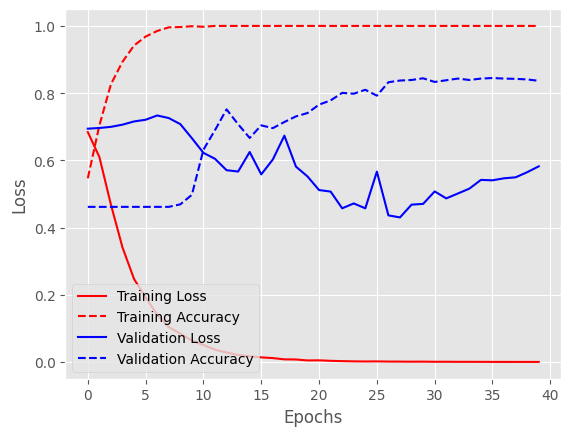

In [ ]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

And, let's evaluate on the test data... 

In [ ]:
model = build_model()
model.fit(data_train,labels_train,epochs=25,batch_size=25)

test_acc = model.evaluate(data_test,labels_test)[1]*100
print(f'The resulting model is about {test_acc:.2f}% accurate in the holdout sample.')

Epoch 1/25
48/48 [==============================] - 2s 7ms/step - loss: 0.6596 - accuracy: 0.6358
Epoch 2/25
48/48 [==============================] - 0s 7ms/step - loss: 0.4876 - accuracy: 0.8067
Epoch 3/25
48/48 [==============================] - 0s 7ms/step - loss: 0.3418 - accuracy: 0.8892
Epoch 4/25
48/48 [==============================] - 0s 7ms/step - loss: 0.2672 - accuracy: 0.9167
Epoch 5/25
48/48 [==============================] - 0s 7ms/step - loss: 0.2096 - accuracy: 0.9500
Epoch 6/25
48/48 [==============================] - 0s 7ms/step - loss: 0.1533 - accuracy: 0.9692
Epoch 7/25
48/48 [==============================] - 0s 7ms/step - loss: 0.1182 - accuracy: 0.9817
Epoch 8/25
48/48 [==============================] - 0s 7ms/step - loss: 0.1033 - accuracy: 0.9817
Epoch 9/25
48/48 [==============================] - 0s 9ms/step - loss: 0.0847 - accuracy: 0.9900
Epoch 10/25
48/48 [==============================] - 0s 7ms/step - loss: 0.0609 - accuracy: 0.9983
Epoch 11/25
48/48 [

#*Model Using Bidirectional LSTM (Still No Embeddings, Yet)*

We will pass our integer sequences into a one-hot encoding layer, and from there into our Bidirectional LSTM.

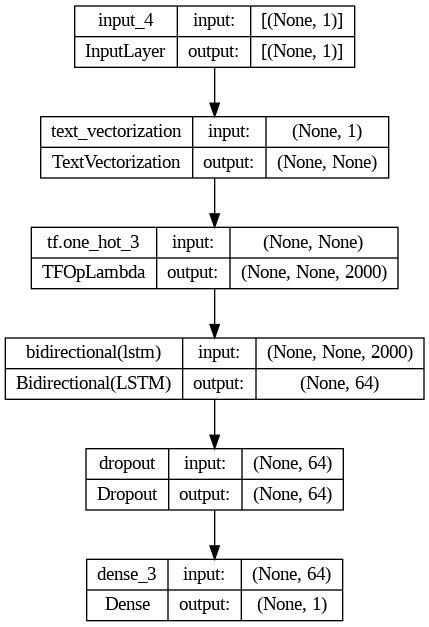

In [ ]:
def build_model():
    inputs = keras.layers.Input(shape=(1), dtype="string") # We take our strings as input 
    processing = text_vectorization(inputs)
    one_hot = tf.one_hot(processing, depth=2000) 
    x = layers.Bidirectional(layers.LSTM(32))(one_hot)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model = build_model()

keras.utils.plot_model(model, show_shapes=True)

Now we will fit our model with cross-validation again, as before... 

In [ ]:
k = 2
num_validation_samples = len(data_train) // k
num_epochs = 25
batch_sizes = 25
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = data_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        data_train[:num_validation_samples * fold],
        data_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    model = build_model()
    history = model.fit(training_data, training_targets, 
                        validation_data = (validation_data,validation_targets), 
                        epochs=num_epochs, batch_size=batch_sizes)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/25
24/24 [==============================] - 6s 67ms/step - loss: 0.6902 - accuracy: 0.5383 - val_loss: 0.6921 - val_accuracy: 0.4667
Epoch 2/25
24/24 [==============================] - 1s 34ms/step - loss: 0.6767 - accuracy: 0.5450 - val_loss: 0.6788 - val_accuracy: 0.4900
Epoch 3/25
24/24 [==============================] - 1s 34ms/step - loss: 0.6377 - accuracy: 0.7033 - val_loss: 0.6220 - val_accuracy: 0.7650
Epoch 4/25
24/24 [==============================] - 1s 34ms/step - loss: 0.5702 - accuracy: 0.7683 - val_loss: 0.5580 - val_accuracy: 0.7967
Epoch 5/25
24/24 [==============================] - 1s 35ms/step - loss: 0.4843 - accuracy: 0.8133 - val_loss: 0.4877 - val_accuracy: 0.8033
Epoch 6/25
24/24 [==============================] - 1s 34ms/step - loss: 0.4486 - accuracy: 0.8300 - val_loss: 0.4850 - val_accuracy: 0.7833
Epoch 7/25
24/24 [==============================] - 1s 35ms/step - loss: 0.3710 - accuracy: 0.8717 - val_loss: 0.4839 - val_accuracy: 0.7867
Epoch 8/25
24

Finally, plot loss / accuracy over training... wow, this model peaks at about the 3rd epoch! It learns much faster than our old model did, though it gets to about the same level of performance. 



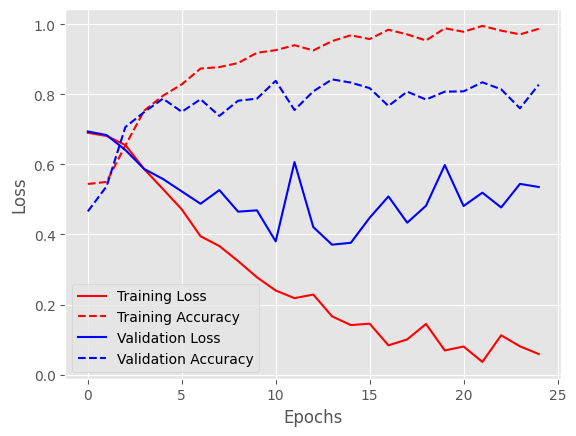

In [ ]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

Let's see how we do on the holdout sample though. But wait! We dropped several features from the original dataset that we used last time. We might want to incorporate those other features into another branch of the network (another input layer). Things like hotel ID, etc. Anyway, this model does not perform quite as well as the 1D convolution!

In [ ]:
model = build_model()
model.fit(data_train,labels_train,epochs=6,batch_size=25)

test_acc = model.evaluate(data_test,labels_test)[1]*100
print(f'The resulting model is about {test_acc:.2f}% accurate in the holdout sample.')

Epoch 1/6
48/48 [==============================] - 4s 24ms/step - loss: 0.6876 - accuracy: 0.5542
Epoch 2/6
48/48 [==============================] - 1s 22ms/step - loss: 0.6289 - accuracy: 0.6942
Epoch 3/6
48/48 [==============================] - 1s 22ms/step - loss: 0.5270 - accuracy: 0.7833
Epoch 4/6
48/48 [==============================] - 1s 22ms/step - loss: 0.4378 - accuracy: 0.8325
Epoch 5/6
48/48 [==============================] - 1s 23ms/step - loss: 0.3687 - accuracy: 0.8717
Epoch 6/6
13/13 [==============================] - 1s 14ms/step - loss: 0.3229 - accuracy: 0.8850
The resulting model is about 88.50% accurate in the holdout sample.


#*Textual Embeddings*

We can pre-process the text using an Embedding layer, before going to LSTM, to 'help the model along.' The Embedding layer will be of shape Vocabular-Size x Vector Length (dimensionality of the latent space). We can feed these sequences of vectors into our LSTM. 

In [ ]:
processing = text_vectorization(data_train)

In [ ]:
print(processing)

tf.Tensor(
[[ 23  17  49 ...   0   0   0]
 [236  16 517 ...   0   0   0]
 [ 25  17  46 ...   0   0   0]
 ...
 [  2  91 444 ...   0   0   0]
 [  6   7  29 ...   0   0   0]
 [ 54  33 198 ...   0   0   0]], shape=(1200, 784), dtype=int64)


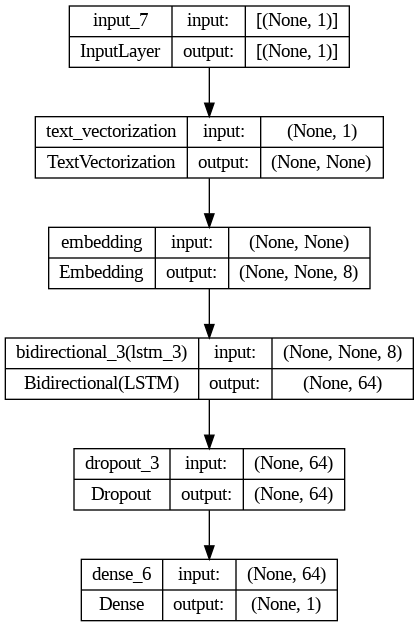

In [ ]:
def build_model_embed():
    inputs = keras.layers.Input(shape=(1), dtype="string") # We take our strings as input 
    processing = text_vectorization(inputs)
    
    # Truncate after 600 tokens, and pad up to 600 tokens for shorter reviews (we already padded, so matters little)).
    # Mask zero means it will yield a boolean mask tensor for the LSTM that tells it to ignore any zeroes.
    embedding = keras.layers.Embedding(input_dim=2000,output_dim=8,input_length=784, mask_zero=True)(processing)
    
    x = keras.layers.Bidirectional(keras.layers.LSTM(32))(embedding)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model_embed = build_model_embed()

keras.utils.plot_model(model_embed, show_shapes=True)

Fit the model again... 

In [ ]:
k = 2
num_validation_samples = len(data_train) // k
num_epochs = 25
batch_sizes = 25
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = data_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        data_train[:num_validation_samples * fold],
        data_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    model = build_model_embed()
    history = model.fit(training_data, training_targets, 
                        validation_data = (validation_data,validation_targets), 
                        epochs=num_epochs, batch_size=batch_sizes)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/25
24/24 [==============================] - 13s 248ms/step - loss: 0.6918 - accuracy: 0.5283 - val_loss: 0.6955 - val_accuracy: 0.4667
Epoch 2/25
24/24 [==============================] - 3s 131ms/step - loss: 0.6885 - accuracy: 0.5433 - val_loss: 0.6966 - val_accuracy: 0.4667
Epoch 3/25
24/24 [==============================] - 3s 139ms/step - loss: 0.6849 - accuracy: 0.5433 - val_loss: 0.6934 - val_accuracy: 0.4667
Epoch 4/25
24/24 [==============================] - 3s 114ms/step - loss: 0.6735 - accuracy: 0.5450 - val_loss: 0.6720 - val_accuracy: 0.5683
Epoch 5/25
24/24 [==============================] - 3s 113ms/step - loss: 0.6058 - accuracy: 0.7467 - val_loss: 0.5687 - val_accuracy: 0.6950
Epoch 6/25
24/24 [==============================] - 2s 100ms/step - loss: 0.5477 - accuracy: 0.7550 - val_loss: 0.6923 - val_accuracy: 0.6517
Epoch 7/25
24/24 [==============================] - 2s 96ms/step - loss: 0.5036 - accuracy: 0.7833 - val_loss: 0.5431 - val_accuracy: 0.7150
Epoch 

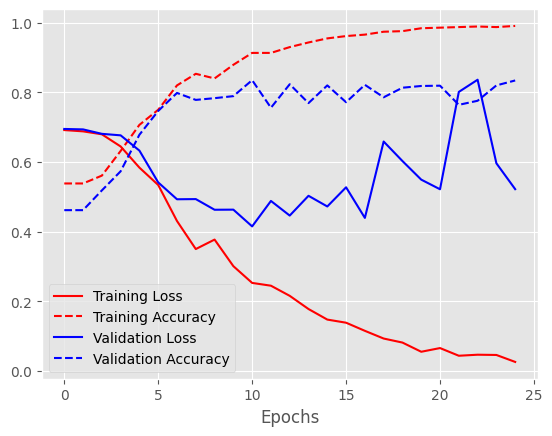

In [ ]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

And we evaluate again on the test data... the custom embedding layer gets us up to 87% accuracy on the holdout data in this case.

In [ ]:
model_embed = build_model_embed()
model_embed.fit(data_train,labels_train,epochs=11,batch_size=25)

test_acc = model_embed.evaluate(data_test,labels_test)[1]*100
print(f'The resulting model is about {test_acc:.2f}% accurate in the holdout sample.')

Epoch 1/11
48/48 [==============================] - 12s 117ms/step - loss: 0.6920 - accuracy: 0.5283
Epoch 2/11
48/48 [==============================] - 5s 98ms/step - loss: 0.6836 - accuracy: 0.6400
Epoch 3/11
48/48 [==============================] - 4s 77ms/step - loss: 0.5489 - accuracy: 0.7350
Epoch 4/11
48/48 [==============================] - 3s 60ms/step - loss: 0.4808 - accuracy: 0.7825
Epoch 5/11
48/48 [==============================] - 3s 56ms/step - loss: 0.3893 - accuracy: 0.8375
Epoch 6/11
48/48 [==============================] - 2s 47ms/step - loss: 0.3365 - accuracy: 0.8625
Epoch 7/11
48/48 [==============================] - 3s 64ms/step - loss: 0.3146 - accuracy: 0.8733
Epoch 8/11
48/48 [==============================] - 2s 36ms/step - loss: 0.2806 - accuracy: 0.8967
Epoch 9/11
48/48 [==============================] - 2s 37ms/step - loss: 0.2055 - accuracy: 0.9175
Epoch 10/11
48/48 [==============================] - 2s 40ms/step - loss: 0.1976 - accuracy: 0.9167
Epoch 1

#*GloVe Embeddings*

Let's see if we can use pre-trained GloVe embeddings to do better here. We will download the GloVe pre-trained embeddings (these are pre-trained embeddings from Wikipedia page data collected in 2014, as well as newswire data). Note that there are also GloVe embeddings that were trained from Twitter, which might be more appropriate for social media data: https://nlp.stanford.edu/projects/glove/

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-04-21 00:27:04--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-21 00:27:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-21 00:27:05--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Note that there are about 1.2 million words in the English language. GloVe contains embeddings for about one third of those words (but that is going to cover most words you will encounter in regular usage!).

In [ ]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt" 
  
embeddings_index = {} 
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1) # Split off only the first element in the row, i.e., the word, keep the remaining values as the vector.
        coefs = np.fromstring(coefs, "f", sep=" ") # Convert the set of numeric values into a numpy array, splitting elements by ' '
        embeddings_index[word] = coefs # Populate our dictionary - for this word (key), the vector representation is this vector (value).
  
glove_vec_lengths = len(coefs)

print(f"Found {len(embeddings_index)} word vectors.")
print(f"GloVe vector representations are {glove_vec_lengths} elements long.")

Found 400000 word vectors.
GloVe vector representations are 100 elements long.


We will now construct the Embedding matrix. This is the mapping between word tokens (integer indices) in our data and their vector representations.

In [ ]:
vocabulary = text_vectorization.get_vocabulary()
print(f"Recall that our vocabulary has {len(vocabulary)} tokens in it.")
print(f"Here is the 11th word in our vocabulary: {vocabulary[13]}.") # Recall that the first two indices are reserved for 'padding' and 'UNK'

Recall that our vocabulary has 2000 tokens in it.
Here is the 11th word in our vocabulary: room.


In [ ]:
embedding_dim = glove_vec_lengths # The length of the vector representations; the latent embedding space will be in 100 dimensions. 

vocabulary = text_vectorization.get_vocabulary() # From the vocabulary our text vectorizer learned from our dataset, go over every word.
word_index = dict(zip(vocabulary, range(len(vocabulary)))) # Make a dictionary, key is word to value is index.

# Instantiate a matrix of values (these will be the 'weights' in our embedding layer)
embedding_matrix = np.zeros((len(vocabulary), embedding_dim)) # It will be the 2000 tokens by 100 (length of GloVe vectors)
for word, i in word_index.items():
    if i < len(vocabulary):
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Here is the GloVe vector embedding for 'room'
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       ...,
       [ 0.38716999, -0.58236998,  0.17566   , ..., -0.30763999,
         0.48519   , -0.51655   ],
       [ 0.48651999,  0.28619   , -0.16289   , ...,  0.46311   ,
        -0.30847999,  0.43871999],
       [-0.085308  ,  0.34345001,  0.24661   , ...,  0.16870999,
        -0.49748001,  0.48736   ]])

Now we use those vector representations to instantiate our Embedding layer. Rather than 'learning' the Embedding layer's weights, we will fix the weights to be the GloVe embeddings, and make them non-trainable. 

In [ ]:
embedding_layer = layers.Embedding(
    len(vocabulary), # 2000 words.
    glove_vec_lengths, # Vectors of 100 elements per word.
    embeddings_initializer=keras.initializers.Constant(embedding_matrix), # Initialize with fixed values from our matrix.
    trainable=False, # These are weights, but they will be frozen so they don't update during training.
    mask_zero=True, # If we have a 0 token, for padding, we don't pass it through the layer.
)

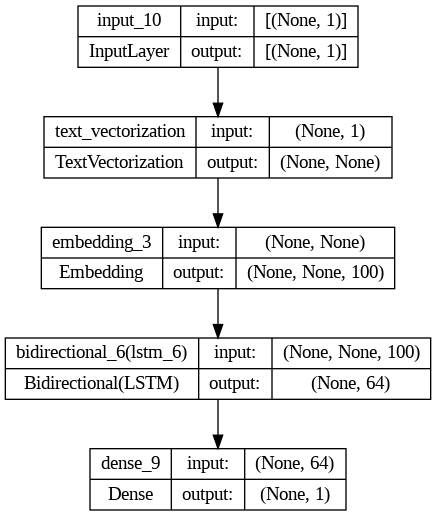

In [ ]:
def build_model_GloVe():
    inputs = keras.layers.Input(shape=(1), dtype="string") # We take our strings as input 
    processing = text_vectorization(inputs)
    
    embedding = embedding_layer(processing)
    
    x = keras.layers.Bidirectional(keras.layers.LSTM(32))(embedding)
   # x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model_GloVe = build_model_GloVe()

keras.utils.plot_model(model_GloVe, show_shapes=True)

And, once again, let's cross validate... 

In [ ]:
k = 2
num_validation_samples = len(data_train) // k
num_epochs = 25
batch_sizes = 25
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = data_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        data_train[:num_validation_samples * fold],
        data_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    model = build_model_GloVe()
    history = model.fit(training_data, training_targets, 
                        validation_data = (validation_data,validation_targets), 
                        epochs=num_epochs, batch_size=batch_sizes)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/25
24/24 [==============================] - 11s 141ms/step - loss: 0.6767 - accuracy: 0.5700 - val_loss: 0.6521 - val_accuracy: 0.6567
Epoch 2/25
24/24 [==============================] - 1s 37ms/step - loss: 0.6313 - accuracy: 0.6433 - val_loss: 0.6353 - val_accuracy: 0.6517
Epoch 3/25
24/24 [==============================] - 1s 37ms/step - loss: 0.5854 - accuracy: 0.6817 - val_loss: 0.6026 - val_accuracy: 0.6733
Epoch 4/25
24/24 [==============================] - 1s 36ms/step - loss: 0.5409 - accuracy: 0.7367 - val_loss: 0.5419 - val_accuracy: 0.7450
Epoch 5/25
24/24 [==============================] - 1s 37ms/step - loss: 0.5153 - accuracy: 0.7467 - val_loss: 0.5252 - val_accuracy: 0.7500
Epoch 6/25
24/24 [==============================] - 1s 40ms/step - loss: 0.4863 - accuracy: 0.7600 - val_loss: 0.6171 - val_accuracy: 0.6683
Epoch 7/25
24/24 [==============================] - 1s 40ms/step - loss: 0.4331 - accuracy: 0.8083 - val_loss: 0.5175 - val_accuracy: 0.7450
Epoch 8/25


Plotting average loss over training once again... 

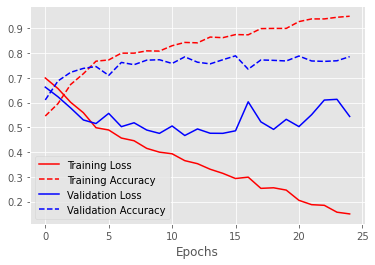

In [ ]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

And, performance on the holdout data? We are actually doing substantially worse using those generic GloVe embeddings.

In [ ]:
model_glove = build_model_GloVe()
model_glove.fit(data_train,labels_train,epochs=9,batch_size=25)

test_acc = model_glove.evaluate(data_test,labels_test)[1]*100
print(f'The resulting model is about {test_acc:.2f}% accurate in the holdout sample.')

Epoch 1/9
48/48 [==============================] - 12s 36ms/step - loss: 0.6607 - accuracy: 0.5983
Epoch 2/9
48/48 [==============================] - 2s 35ms/step - loss: 0.5598 - accuracy: 0.7150
Epoch 3/9
48/48 [==============================] - 2s 36ms/step - loss: 0.5087 - accuracy: 0.7567
Epoch 4/9
48/48 [==============================] - 2s 36ms/step - loss: 0.4737 - accuracy: 0.7800
Epoch 5/9
48/48 [==============================] - 2s 36ms/step - loss: 0.4620 - accuracy: 0.7875
Epoch 6/9
48/48 [==============================] - 2s 35ms/step - loss: 0.4562 - accuracy: 0.7842
Epoch 7/9
48/48 [==============================] - 2s 36ms/step - loss: 0.4217 - accuracy: 0.8000
Epoch 8/9
48/48 [==============================] - 2s 39ms/step - loss: 0.4188 - accuracy: 0.8050
Epoch 9/9
13/13 [==============================] - 3s 21ms/step - loss: 0.5963 - accuracy: 0.7325
The resulting model is about 73.25% accurate in the holdout sample.


#*Word2Vec Embeddings*

Now we will try out the word2vec pre-trained embeddings (from Wikipedia). Let's download the English language, Wikipedia 100-dimensional embeddings. Note that this can take some time because the embedding file is large. 

In [ ]:
!wget http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.pkl.bz2
!bzip2 -d enwiki_20180420_100d.pkl.bz2

--2023-04-20 21:51:20--  http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.pkl.bz2
Resolving wikipedia2vec.s3.amazonaws.com (wikipedia2vec.s3.amazonaws.com)... 52.219.8.77, 52.219.68.201, 52.219.4.81, ...
Connecting to wikipedia2vec.s3.amazonaws.com (wikipedia2vec.s3.amazonaws.com)|52.219.8.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3514838671 (3.3G) [application/x-bzip2]
Saving to: ‘enwiki_20180420_100d.pkl.bz2’

enwiki_20180420_100 100%[===================>]   3.27G  12.8MB/s    in 4m 24s  

2023-04-20 21:55:45 (12.7 MB/s) - ‘enwiki_20180420_100d.pkl.bz2’ saved [3514838671/3514838671]



Now let's create an embedding matrix, as before, etc. Note, we can see that most of the words for which we lack embeddings are actually typos or proper nouns. We could manually fix the typos, or not (perhaps the typos are indicative of deceipt!

In [ ]:
try:
  from wikipedia2vec import Wikipedia2Vec
except ImportError as error:
  !pip install wikipedia2vec
  from wikipedia2vec import Wikipedia2Vec

from wikipedia2vec import Wikipedia2Vec

# These embeddings are 100 dimensional also.
embedding_dim = 100

wiki2vec = Wikipedia2Vec.load('enwiki_20180420_100d.pkl')

vocabulary = text_vectorization.get_vocabulary() # From the vocabulary our text vectorizer learned from our dataset, go over every word.
word_index = dict(zip(vocabulary, range(len(vocabulary)))) # Make a dictionary, key is word to value is index.
embedding_matrix = np.zeros((len(vocabulary), embedding_dim))

for word, index in word_index.items():
    try:
        embedding_matrix[index] = wiki2vec.get_word_vector(f'{word}')
    except:
        print(f'Skipping {word}, no embedding for it.')
        continue

print(f'The embedding for \'room\' is {embedding_matrix[15]}.')

Skipping , no embedding for it.
Skipping [UNK], no embedding for it.
Skipping werent, no embedding for it.
Skipping inroom, no embedding for it.
Skipping hadnt, no embedding for it.
Skipping definately, no embedding for it.
Skipping shouldnt, no embedding for it.
Skipping accomodating, no embedding for it.
Skipping ohare, no embedding for it.
Skipping accomodations, no embedding for it.
Skipping definetly, no embedding for it.
Skipping shulas, no embedding for it.
The embedding for 'room' is [-0.04475478  0.52349627  0.15551241  0.13616104  0.00284019 -0.08661265
  0.05645907 -0.20347282  0.02514262 -0.50536108 -0.38650605 -0.0852759
  0.29945976 -0.11940839 -0.06857705 -0.17449841  0.2246068   0.13887054
  0.15167743  0.17579257  0.04217658 -0.10980772  0.09993367  0.01266596
 -0.20744962 -0.50846672  0.27036953 -0.18056074 -0.01523099  0.32400358
  0.19859086 -0.16741541 -0.17544943 -0.2759535  -0.40312016 -0.3360047
 -0.26442048 -0.25339603  0.28910047 -0.36898452  0.09097765 -0.053

And, again, let's make our embedding layer... 

In [ ]:
embedding_layer = layers.Embedding(
    len(vocabulary), # 2000 words.
    100, # Vectors of 100 elements per word.
    embeddings_initializer=keras.initializers.Constant(embedding_matrix), # Initialize with fixed values from our matrix.
    trainable=False, # These are weights, but they will be frozen so they don't update during training.
    mask_zero=True, # If we have a 0 token, for padding, we don't pass it through the layer.
)

And we instantiate the model again... 

In [ ]:
def build_model_word2vec():
    inputs = keras.layers.Input(shape=(1), dtype="string") # We take our strings as input 
    processing = text_vectorization(inputs)
    
    embedding = embedding_layer(processing)
    
    x = keras.layers.Bidirectional(keras.layers.LSTM(32))(embedding)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model_word2vec = build_model_word2vec()

And, let's fit the model one last time... once again, these don't help! The embeddings actually hurt. 

In [ ]:
k = 2
num_validation_samples = len(data_train) // k
num_epochs = 25
batch_sizes = 25
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = data_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        data_train[:num_validation_samples * fold],
        data_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    model = build_model_word2vec()
    history = model.fit(training_data, training_targets, 
                        validation_data = (validation_data,validation_targets), 
                        epochs=num_epochs, batch_size=batch_sizes)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/25
24/24 [==============================] - 14s 186ms/step - loss: 0.6817 - accuracy: 0.5767 - val_loss: 0.6501 - val_accuracy: 0.6333
Epoch 2/25
24/24 [==============================] - 1s 53ms/step - loss: 0.6512 - accuracy: 0.6050 - val_loss: 0.6017 - val_accuracy: 0.7000
Epoch 3/25
24/24 [==============================] - 1s 53ms/step - loss: 0.5921 - accuracy: 0.6767 - val_loss: 0.5598 - val_accuracy: 0.7383
Epoch 4/25
24/24 [==============================] - 1s 53ms/step - loss: 0.5585 - accuracy: 0.7300 - val_loss: 0.5230 - val_accuracy: 0.7600
Epoch 5/25
24/24 [==============================] - 1s 53ms/step - loss: 0.5351 - accuracy: 0.7367 - val_loss: 0.5553 - val_accuracy: 0.7200
Epoch 6/25
24/24 [==============================] - 1s 53ms/step - loss: 0.5115 - accuracy: 0.7467 - val_loss: 0.4838 - val_accuracy: 0.7567
Epoch 7/25
24/24 [==============================] - 1s 52ms/step - loss: 0.4977 - accuracy: 0.7767 - val_loss: 0.5251 - val_accuracy: 0.7217
Epoch 8/25


Plotting average model loss / accuracy across folds, over training.

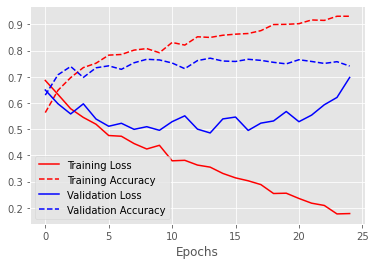

In [ ]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

And, again, performance on the holdout data, which is what ultimately matters? Again, performance of about 77%. These pre-trained embeddings are doing more harm than good in this setting.

In [ ]:
model_word2vec = build_model_word2vec()
model_word2vec.fit(data_train,labels_train,epochs=9,batch_size=25)

test_acc = model_word2vec.evaluate(data_test,labels_test)[1]*100
print(f'The resulting model is about {test_acc:.2f}% accurate in the holdout sample.')

Epoch 1/9
48/48 [==============================] - 12s 36ms/step - loss: 0.6801 - accuracy: 0.5750
Epoch 2/9
48/48 [==============================] - 2s 36ms/step - loss: 0.5922 - accuracy: 0.6908
Epoch 3/9
48/48 [==============================] - 2s 35ms/step - loss: 0.5353 - accuracy: 0.7467
Epoch 4/9
48/48 [==============================] - 2s 37ms/step - loss: 0.4885 - accuracy: 0.7708
Epoch 5/9
48/48 [==============================] - 2s 35ms/step - loss: 0.4760 - accuracy: 0.7725
Epoch 6/9
48/48 [==============================] - 2s 36ms/step - loss: 0.4306 - accuracy: 0.8033
Epoch 7/9
48/48 [==============================] - 2s 36ms/step - loss: 0.4365 - accuracy: 0.7883
Epoch 8/9
48/48 [==============================] - 2s 36ms/step - loss: 0.4093 - accuracy: 0.8150
Epoch 9/9
13/13 [==============================] - 3s 20ms/step - loss: 0.4987 - accuracy: 0.7625
The resulting model is about 76.25% accurate in the holdout sample.
